# Simple object detector using opencv and YOLO V3

In [171]:
import numpy as np
import cv2
import os
import time

In [172]:
np.random.seed(42)

# Load class labels and model

In [173]:
# load the COCO class labels the YOLO model was trained on
labelsPath = './coco.names'
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [174]:
# file paths to the YOLO weights and model configuration
weightsPath = './yolov3.weights'
configPath = './yolov3.cfg'

# load the YOLO object detector trained on COCO dataset (80 classes)
print('Loading YOLO ...')
yolo = cv2.dnn.readNet(model=weightsPath, config=configPath)

Loading YOLO ...


# Preprocess image and perform forward pass

In [175]:
image = cv2.imread('./car_pedestrian.jpeg')
(H, W) = image.shape[:2]

# determine only the *output* layer names that we need from YOLO
ln = yolo.getLayerNames()
print(ln)

print(yolo.getUnconnectedOutLayers())

ln = [ln[i[0] - 1] for i in yolo.getUnconnectedOutLayers()]
print(ln)

['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

In [176]:
# preprocess the input image and then perform a forward pass
# giving us our bounding boxes and associated probabilities
blob = cv2.dnn.blobFromImage(image, scalefactor = 1/255.0, size=(416, 416), swapRB=True, crop=False)
yolo.setInput(blob)

start = time.time()
layerOutputs = yolo.forward(ln)  # runs forward pass to compute output of layer by name
end = time.time()

# show timing information on YOLO
print("[YOLO took {:.6f} seconds".format(end - start))

[YOLO took 2.419388 seconds


# Non-Max Suppression

In [177]:
# lists of detected bounding boxes, confidences, and class IDs
boxes = []
confidences = []
classIDs = []

# probability that a object is indeed present in the image
confidence_threshold = 0.5  

# to remove other bounding boxes that overlap a lot (Intersection over Union IoU)
nms_threshold = 0.5    

In [178]:
for output in layerOutputs:
	
	for detection in output:
		# extract the class ID and confidence (i.e., probability)
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]

		# filter out weak predictions by ensuring the detected probability is greater than the minimum probability
		if confidence > confidence_threshold:
			# scale the bounding box coordinates back relative to the
			# size of the image
      # YOLO returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")

			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))

			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [179]:
# apply non-max suppression to remove weak, overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

print(idxs)

[[ 8]
 [ 3]
 [ 9]
 [ 6]
 [10]
 [ 5]
 [ 7]
 [11]
 [ 4]]


# Results

In [180]:
from google.colab.patches import cv2_imshow

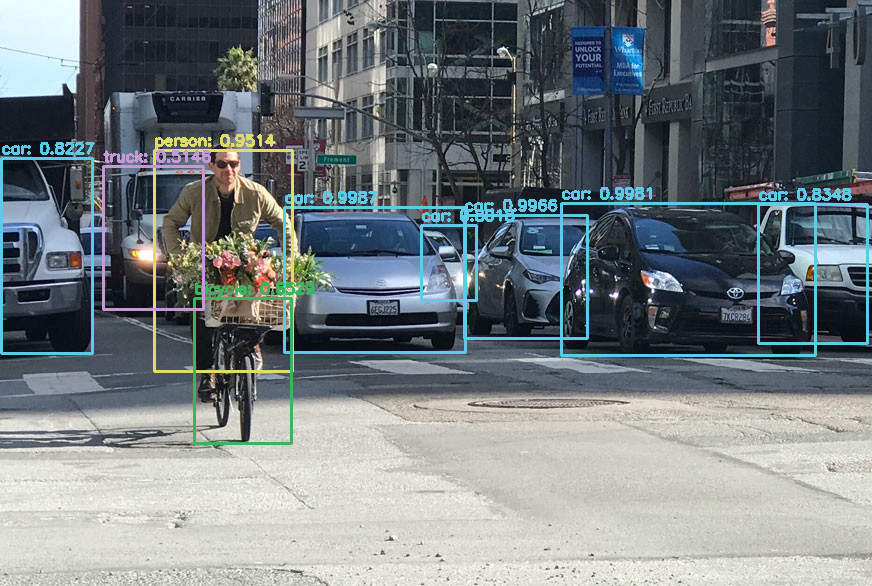

In [181]:
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])

		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

cv2_imshow(image)